<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:09:54] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


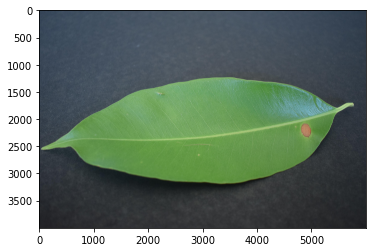

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

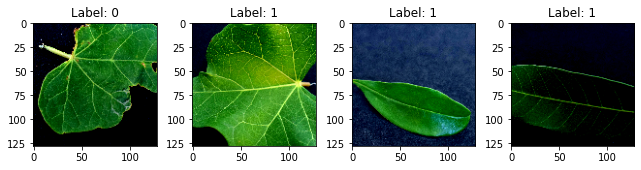

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:03] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2568969242419383 samples/sec                   batch loss = 1.6925183534622192 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2640364669486635 samples/sec                   batch loss = 0.4316669702529907 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2638187006601422 samples/sec                   batch loss = 0.7009725570678711 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2580209142065828 samples/sec                   batch loss = 0.7182508707046509 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2663795981528925 samples/sec                   batch loss = 0.27755847573280334 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2619008990693101 samples/sec                   batch loss = 0.5268377065658569 | accuracy = 0.5


Epoch[1] Batch[35] Speed: 1.2660504751986117 samples/sec                   batch loss = 0.16410808265209198 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2695896592546045 samples/sec                   batch loss = 0.4622645974159241 | accuracy = 0.5375


Epoch[1] Batch[45] Speed: 1.2694466208616493 samples/sec                   batch loss = 0.7518715858459473 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.262448696045818 samples/sec                   batch loss = 0.4018399119377136 | accuracy = 0.545


Epoch[1] Batch[55] Speed: 1.2703954644656554 samples/sec                   batch loss = 0.6096105575561523 | accuracy = 0.5454545454545454


Epoch[1] Batch[60] Speed: 1.2686168851285489 samples/sec                   batch loss = 0.8857479095458984 | accuracy = 0.5375


Epoch[1] Batch[65] Speed: 1.2663154611828775 samples/sec                   batch loss = 0.8574122786521912 | accuracy = 0.5346153846153846


Epoch[1] Batch[70] Speed: 1.263265148614526 samples/sec                   batch loss = 0.4000071585178375 | accuracy = 0.5535714285714286


Epoch[1] Batch[75] Speed: 1.2689674994355638 samples/sec                   batch loss = 0.9535011053085327 | accuracy = 0.5533333333333333


Epoch[1] Batch[80] Speed: 1.2638418353606746 samples/sec                   batch loss = 0.5593177676200867 | accuracy = 0.55625


Epoch[1] Batch[85] Speed: 1.2667163521334008 samples/sec                   batch loss = 0.7305265665054321 | accuracy = 0.5617647058823529


Epoch[1] Batch[90] Speed: 1.2631868701934652 samples/sec                   batch loss = 0.9253020882606506 | accuracy = 0.5583333333333333


Epoch[1] Batch[95] Speed: 1.2600310193307163 samples/sec                   batch loss = 0.499042272567749 | accuracy = 0.5684210526315789


Epoch[1] Batch[100] Speed: 1.262240972896363 samples/sec                   batch loss = 0.7220677137374878 | accuracy = 0.5725


Epoch[1] Batch[105] Speed: 1.263851165644181 samples/sec                   batch loss = 0.4469242990016937 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.260425478462681 samples/sec                   batch loss = 1.2012203931808472 | accuracy = 0.5909090909090909


Epoch[1] Batch[115] Speed: 1.2710724692141833 samples/sec                   batch loss = 0.8367074131965637 | accuracy = 0.5869565217391305


Epoch[1] Batch[120] Speed: 1.2618639785757404 samples/sec                   batch loss = 0.46224796772003174 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.2656770266470734 samples/sec                   batch loss = 0.23311826586723328 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.2604074871913686 samples/sec                   batch loss = 0.41553428769111633 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2621706075794563 samples/sec                   batch loss = 1.154064416885376 | accuracy = 0.6055555555555555


Epoch[1] Batch[140] Speed: 1.2675911039626653 samples/sec                   batch loss = 0.5419116020202637 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.2671616164263482 samples/sec                   batch loss = 0.8811019659042358 | accuracy = 0.6


Epoch[1] Batch[150] Speed: 1.2612018647235022 samples/sec                   batch loss = 0.5566751956939697 | accuracy = 0.6016666666666667


Epoch[1] Batch[155] Speed: 1.260503130894093 samples/sec                   batch loss = 0.6847035884857178 | accuracy = 0.6016129032258064


Epoch[1] Batch[160] Speed: 1.265676071818139 samples/sec                   batch loss = 0.39491239190101624 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2629079811339319 samples/sec                   batch loss = 0.5250848531723022 | accuracy = 0.6075757575757575


Epoch[1] Batch[170] Speed: 1.2664278724376246 samples/sec                   batch loss = 0.5940881371498108 | accuracy = 0.6073529411764705


Epoch[1] Batch[175] Speed: 1.2609667823671658 samples/sec                   batch loss = 0.8392699360847473 | accuracy = 0.6128571428571429


Epoch[1] Batch[180] Speed: 1.2673338168835366 samples/sec                   batch loss = 0.22313717007637024 | accuracy = 0.6194444444444445


Epoch[1] Batch[185] Speed: 1.263089202220786 samples/sec                   batch loss = 0.3876887261867523 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2657368972983576 samples/sec                   batch loss = 1.7913460731506348 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2658729880276682 samples/sec                   batch loss = 0.5055269002914429 | accuracy = 0.6282051282051282


Epoch[1] Batch[200] Speed: 1.2618148178789268 samples/sec                   batch loss = 0.8685667514801025 | accuracy = 0.6275


Epoch[1] Batch[205] Speed: 1.2651523743566109 samples/sec                   batch loss = 0.3429148495197296 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.2632296700721801 samples/sec                   batch loss = 0.3974296748638153 | accuracy = 0.6345238095238095


Epoch[1] Batch[215] Speed: 1.2624831807153267 samples/sec                   batch loss = 0.48662060499191284 | accuracy = 0.6337209302325582


Epoch[1] Batch[220] Speed: 1.2620904709446847 samples/sec                   batch loss = 0.6895152926445007 | accuracy = 0.6306818181818182


Epoch[1] Batch[225] Speed: 1.2626487903728953 samples/sec                   batch loss = 0.5610273480415344 | accuracy = 0.6333333333333333


Epoch[1] Batch[230] Speed: 1.2626091655199325 samples/sec                   batch loss = 0.7422619462013245 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2674873913938889 samples/sec                   batch loss = 0.5032933950424194 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2655691400931623 samples/sec                   batch loss = 0.41425079107284546 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.262855221914761 samples/sec                   batch loss = 0.8533483743667603 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2587971735238979 samples/sec                   batch loss = 0.41460153460502625 | accuracy = 0.64


Epoch[1] Batch[255] Speed: 1.2561306239235859 samples/sec                   batch loss = 0.9454197883605957 | accuracy = 0.6372549019607843


Epoch[1] Batch[260] Speed: 1.256234367470141 samples/sec                   batch loss = 1.3471534252166748 | accuracy = 0.6375


Epoch[1] Batch[265] Speed: 1.2581996974270047 samples/sec                   batch loss = 0.36300763487815857 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2594910856700408 samples/sec                   batch loss = 0.5222684741020203 | accuracy = 0.6425925925925926


Epoch[1] Batch[275] Speed: 1.2573042161902905 samples/sec                   batch loss = 0.4891812801361084 | accuracy = 0.6418181818181818


Epoch[1] Batch[280] Speed: 1.2571180574288074 samples/sec                   batch loss = 0.5137388110160828 | accuracy = 0.64375


Epoch[1] Batch[285] Speed: 1.2562241146249875 samples/sec                   batch loss = 0.5285619497299194 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.2602076292469866 samples/sec                   batch loss = 0.6229366064071655 | accuracy = 0.646551724137931


Epoch[1] Batch[295] Speed: 1.261907827834574 samples/sec                   batch loss = 0.3997112512588501 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.25765473238131 samples/sec                   batch loss = 0.8284376263618469 | accuracy = 0.6441666666666667


Epoch[1] Batch[305] Speed: 1.258157332059869 samples/sec                   batch loss = 0.3874897062778473 | accuracy = 0.6426229508196721


Epoch[1] Batch[310] Speed: 1.258737296497879 samples/sec                   batch loss = 0.12953467667102814 | accuracy = 0.6443548387096775


Epoch[1] Batch[315] Speed: 1.260586381138799 samples/sec                   batch loss = 0.537075400352478 | accuracy = 0.6452380952380953


Epoch[1] Batch[320] Speed: 1.2588538447259003 samples/sec                   batch loss = 0.6850674748420715 | accuracy = 0.64765625


Epoch[1] Batch[325] Speed: 1.2600130393185547 samples/sec                   batch loss = 1.0031033754348755 | accuracy = 0.6476923076923077


Epoch[1] Batch[330] Speed: 1.2636901899676176 samples/sec                   batch loss = 0.5300891995429993 | accuracy = 0.6484848484848484


Epoch[1] Batch[335] Speed: 1.2640632287181341 samples/sec                   batch loss = 0.7780998349189758 | accuracy = 0.6477611940298508


Epoch[1] Batch[340] Speed: 1.2668487315101327 samples/sec                   batch loss = 0.40106266736984253 | accuracy = 0.649264705882353


Epoch[1] Batch[345] Speed: 1.265498594143224 samples/sec                   batch loss = 0.42243218421936035 | accuracy = 0.6514492753623189


Epoch[1] Batch[350] Speed: 1.2665336107587766 samples/sec                   batch loss = 0.4474543333053589 | accuracy = 0.6528571428571428


Epoch[1] Batch[355] Speed: 1.266104743858392 samples/sec                   batch loss = 0.4967266023159027 | accuracy = 0.6542253521126761


Epoch[1] Batch[360] Speed: 1.2637988035910799 samples/sec                   batch loss = 0.3956625759601593 | accuracy = 0.6555555555555556


Epoch[1] Batch[365] Speed: 1.2657165578294203 samples/sec                   batch loss = 0.5329421758651733 | accuracy = 0.6561643835616439


Epoch[1] Batch[370] Speed: 1.263462932822924 samples/sec                   batch loss = 0.6092833876609802 | accuracy = 0.6567567567567567


Epoch[1] Batch[375] Speed: 1.2625022763427411 samples/sec                   batch loss = 1.4850049018859863 | accuracy = 0.6566666666666666


Epoch[1] Batch[380] Speed: 1.260736998258196 samples/sec                   batch loss = 0.44652193784713745 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2606057035869283 samples/sec                   batch loss = 0.9339072108268738 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2594550624231853 samples/sec                   batch loss = 0.8518226742744446 | accuracy = 0.6564102564102564


Epoch[1] Batch[395] Speed: 1.2647242515234804 samples/sec                   batch loss = 0.5683351159095764 | accuracy = 0.6563291139240506


Epoch[1] Batch[400] Speed: 1.2646333044057623 samples/sec                   batch loss = 0.2621351480484009 | accuracy = 0.658125


Epoch[1] Batch[405] Speed: 1.2611892552599304 samples/sec                   batch loss = 0.5538572669029236 | accuracy = 0.6580246913580247


Epoch[1] Batch[410] Speed: 1.2568951351510094 samples/sec                   batch loss = 0.5149472951889038 | accuracy = 0.6579268292682927


Epoch[1] Batch[415] Speed: 1.263966377435526 samples/sec                   batch loss = 0.3572044372558594 | accuracy = 0.658433734939759


Epoch[1] Batch[420] Speed: 1.2636339390669205 samples/sec                   batch loss = 0.44577091932296753 | accuracy = 0.6607142857142857


Epoch[1] Batch[425] Speed: 1.260771484221622 samples/sec                   batch loss = 0.5743991732597351 | accuracy = 0.6629411764705883


Epoch[1] Batch[430] Speed: 1.2611994945043397 samples/sec                   batch loss = 1.1531785726547241 | accuracy = 0.6627906976744186


Epoch[1] Batch[435] Speed: 1.2620941737165972 samples/sec                   batch loss = 0.35933956503868103 | accuracy = 0.6620689655172414


Epoch[1] Batch[440] Speed: 1.2631499695152388 samples/sec                   batch loss = 0.4994114339351654 | accuracy = 0.6630681818181818


Epoch[1] Batch[445] Speed: 1.2630718955478513 samples/sec                   batch loss = 0.5563749074935913 | accuracy = 0.6629213483146067


Epoch[1] Batch[450] Speed: 1.2623518070577626 samples/sec                   batch loss = 0.2297285795211792 | accuracy = 0.6644444444444444


Epoch[1] Batch[455] Speed: 1.26123362651983 samples/sec                   batch loss = 0.3176543414592743 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.2597312933212426 samples/sec                   batch loss = 0.22953440248966217 | accuracy = 0.6668478260869565


Epoch[1] Batch[465] Speed: 1.2635735058625832 samples/sec                   batch loss = 0.7130131721496582 | accuracy = 0.667741935483871


Epoch[1] Batch[470] Speed: 1.2645072965812163 samples/sec                   batch loss = 0.5684779286384583 | accuracy = 0.6691489361702128


Epoch[1] Batch[475] Speed: 1.2662367087235695 samples/sec                   batch loss = 0.41288745403289795 | accuracy = 0.6705263157894736


Epoch[1] Batch[480] Speed: 1.264294417575614 samples/sec                   batch loss = 0.5010882616043091 | accuracy = 0.6692708333333334


Epoch[1] Batch[485] Speed: 1.275559404325913 samples/sec                   batch loss = 0.6514348387718201 | accuracy = 0.6701030927835051


Epoch[1] Batch[490] Speed: 1.2737901370265305 samples/sec                   batch loss = 0.5727091431617737 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.2668865182718674 samples/sec                   batch loss = 0.9244190454483032 | accuracy = 0.6707070707070707


Epoch[1] Batch[500] Speed: 1.262571538465417 samples/sec                   batch loss = 0.9400346875190735 | accuracy = 0.669


Epoch[1] Batch[505] Speed: 1.2680268246536552 samples/sec                   batch loss = 0.21775981783866882 | accuracy = 0.6702970297029703


Epoch[1] Batch[510] Speed: 1.2681061833458238 samples/sec                   batch loss = 0.6957159638404846 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.26704151540957 samples/sec                   batch loss = 0.465882271528244 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.269222377728184 samples/sec                   batch loss = 0.7665649652481079 | accuracy = 0.6697115384615384


Epoch[1] Batch[525] Speed: 1.2601896441942375 samples/sec                   batch loss = 0.7924997806549072 | accuracy = 0.6704761904761904


Epoch[1] Batch[530] Speed: 1.2637465410684845 samples/sec                   batch loss = 0.6083014607429504 | accuracy = 0.6702830188679245


Epoch[1] Batch[535] Speed: 1.2618222202099245 samples/sec                   batch loss = 0.2875545620918274 | accuracy = 0.6696261682242991


Epoch[1] Batch[540] Speed: 1.2666381235726722 samples/sec                   batch loss = 0.4868069589138031 | accuracy = 0.6699074074074074


Epoch[1] Batch[545] Speed: 1.2645122525416355 samples/sec                   batch loss = 0.4359303414821625 | accuracy = 0.671559633027523


Epoch[1] Batch[550] Speed: 1.268446541567608 samples/sec                   batch loss = 0.41220778226852417 | accuracy = 0.6722727272727272


Epoch[1] Batch[555] Speed: 1.2607777373730906 samples/sec                   batch loss = 0.9562029838562012 | accuracy = 0.672972972972973


Epoch[1] Batch[560] Speed: 1.2639429525107255 samples/sec                   batch loss = 0.5301374793052673 | accuracy = 0.6732142857142858


Epoch[1] Batch[565] Speed: 1.2630385197321914 samples/sec                   batch loss = 0.8739708662033081 | accuracy = 0.6743362831858407


Epoch[1] Batch[570] Speed: 1.2592091949833728 samples/sec                   batch loss = 0.32439300417900085 | accuracy = 0.6741228070175439


Epoch[1] Batch[575] Speed: 1.2667090835469843 samples/sec                   batch loss = 0.3622681498527527 | accuracy = 0.6752173913043479


Epoch[1] Batch[580] Speed: 1.2647201519483993 samples/sec                   batch loss = 0.3060912489891052 | accuracy = 0.6767241379310345


Epoch[1] Batch[585] Speed: 1.266938658137652 samples/sec                   batch loss = 0.1184435486793518 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.269645096498823 samples/sec                   batch loss = 0.46558162569999695 | accuracy = 0.6779661016949152


Epoch[1] Batch[595] Speed: 1.263004575199071 samples/sec                   batch loss = 0.6909085512161255 | accuracy = 0.6773109243697479


Epoch[1] Batch[600] Speed: 1.2666121132822996 samples/sec                   batch loss = 0.9046273231506348 | accuracy = 0.6775


Epoch[1] Batch[605] Speed: 1.2651775614670653 samples/sec                   batch loss = 0.5309708118438721 | accuracy = 0.6785123966942149


Epoch[1] Batch[610] Speed: 1.2648014810433374 samples/sec                   batch loss = 0.361045241355896 | accuracy = 0.6799180327868852


Epoch[1] Batch[615] Speed: 1.2613917008005677 samples/sec                   batch loss = 0.9746929407119751 | accuracy = 0.6796747967479675


Epoch[1] Batch[620] Speed: 1.2688370759146106 samples/sec                   batch loss = 1.0485649108886719 | accuracy = 0.6782258064516129


Epoch[1] Batch[625] Speed: 1.2636624921977735 samples/sec                   batch loss = 0.6331809163093567 | accuracy = 0.6792


Epoch[1] Batch[630] Speed: 1.2667558526205887 samples/sec                   batch loss = 0.7347649931907654 | accuracy = 0.6773809523809524


Epoch[1] Batch[635] Speed: 1.2639391436619318 samples/sec                   batch loss = 0.36102375388145447 | accuracy = 0.6779527559055119


Epoch[1] Batch[640] Speed: 1.261320007734573 samples/sec                   batch loss = 0.6192870736122131 | accuracy = 0.678515625


Epoch[1] Batch[645] Speed: 1.2630822604763259 samples/sec                   batch loss = 0.7255009412765503 | accuracy = 0.6782945736434108


Epoch[1] Batch[650] Speed: 1.2625741038751654 samples/sec                   batch loss = 0.8382278084754944 | accuracy = 0.6784615384615384


Epoch[1] Batch[655] Speed: 1.2680141741858857 samples/sec                   batch loss = 0.384859561920166 | accuracy = 0.6790076335877863


Epoch[1] Batch[660] Speed: 1.2629969688312441 samples/sec                   batch loss = 0.35791072249412537 | accuracy = 0.6795454545454546


Epoch[1] Batch[665] Speed: 1.2671324264355903 samples/sec                   batch loss = 0.3427298367023468 | accuracy = 0.6789473684210526


Epoch[1] Batch[670] Speed: 1.2612374190800355 samples/sec                   batch loss = 0.22702889144420624 | accuracy = 0.6809701492537313


Epoch[1] Batch[675] Speed: 1.2681861271430743 samples/sec                   batch loss = 0.5985025763511658 | accuracy = 0.68


Epoch[1] Batch[680] Speed: 1.267293418800449 samples/sec                   batch loss = 0.4982132911682129 | accuracy = 0.6801470588235294


Epoch[1] Batch[685] Speed: 1.2652773657109044 samples/sec                   batch loss = 0.4381929934024811 | accuracy = 0.6806569343065694


Epoch[1] Batch[690] Speed: 1.266448425972902 samples/sec                   batch loss = 0.596293568611145 | accuracy = 0.6804347826086956


Epoch[1] Batch[695] Speed: 1.2651461731385711 samples/sec                   batch loss = 0.9150186777114868 | accuracy = 0.6802158273381295


Epoch[1] Batch[700] Speed: 1.26762500815064 samples/sec                   batch loss = 0.9663971662521362 | accuracy = 0.6807142857142857


Epoch[1] Batch[705] Speed: 1.2690508156139122 samples/sec                   batch loss = 0.5249968767166138 | accuracy = 0.6794326241134752


Epoch[1] Batch[710] Speed: 1.2616382316055823 samples/sec                   batch loss = 0.45642033219337463 | accuracy = 0.680281690140845


Epoch[1] Batch[715] Speed: 1.2626604787541689 samples/sec                   batch loss = 0.16619037091732025 | accuracy = 0.6797202797202797


Epoch[1] Batch[720] Speed: 1.2654934395377693 samples/sec                   batch loss = 0.6494315266609192 | accuracy = 0.6798611111111111


Epoch[1] Batch[725] Speed: 1.2665780720162325 samples/sec                   batch loss = 0.8091707825660706 | accuracy = 0.6796551724137931


Epoch[1] Batch[730] Speed: 1.26092650487202 samples/sec                   batch loss = 0.35720932483673096 | accuracy = 0.6794520547945205


Epoch[1] Batch[735] Speed: 1.2579164038074855 samples/sec                   batch loss = 0.8557831645011902 | accuracy = 0.6795918367346939


Epoch[1] Batch[740] Speed: 1.265987517917677 samples/sec                   batch loss = 0.9293949604034424 | accuracy = 0.6787162162162163


Epoch[1] Batch[745] Speed: 1.2676749099861908 samples/sec                   batch loss = 0.35591432452201843 | accuracy = 0.6791946308724832


Epoch[1] Batch[750] Speed: 1.2681197941676916 samples/sec                   batch loss = 0.3147984743118286 | accuracy = 0.6796666666666666


Epoch[1] Batch[755] Speed: 1.2621262653166345 samples/sec                   batch loss = 0.4306281507015228 | accuracy = 0.6801324503311258


Epoch[1] Batch[760] Speed: 1.26548446680622 samples/sec                   batch loss = 0.45530587434768677 | accuracy = 0.680921052631579


Epoch[1] Batch[765] Speed: 1.2625674528343773 samples/sec                   batch loss = 0.29174432158470154 | accuracy = 0.6816993464052288


Epoch[1] Batch[770] Speed: 1.2581292158634576 samples/sec                   batch loss = 0.3078531324863434 | accuracy = 0.6827922077922078


Epoch[1] Batch[775] Speed: 1.2579022566222524 samples/sec                   batch loss = 0.4630979597568512 | accuracy = 0.6825806451612904


Epoch[1] Batch[780] Speed: 1.2594850343769601 samples/sec                   batch loss = 0.416017085313797 | accuracy = 0.6830128205128205


Epoch[1] Batch[785] Speed: 1.2674556968480217 samples/sec                   batch loss = 1.0914877653121948 | accuracy = 0.682484076433121


[Epoch 1] training: accuracy=0.6833756345177665
[Epoch 1] time cost: 650.786997795105
[Epoch 1] validation: validation accuracy=0.7622222222222222


Epoch[2] Batch[5] Speed: 1.256498365307461 samples/sec                   batch loss = 0.644071638584137 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2620067371351364 samples/sec                   batch loss = 0.55208420753479 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2595846044510806 samples/sec                   batch loss = 0.36967435479164124 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2608155418370892 samples/sec                   batch loss = 0.41002917289733887 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2582162103138652 samples/sec                   batch loss = 0.4065491557121277 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2558478851470523 samples/sec                   batch loss = 1.0440157651901245 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2555980677045804 samples/sec                   batch loss = 0.44496387243270874 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2518271090612627 samples/sec                   batch loss = 0.6018214821815491 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.2575598974806177 samples/sec                   batch loss = 0.38875773549079895 | accuracy = 0.6777777777777778


Epoch[2] Batch[50] Speed: 1.2628010413590054 samples/sec                   batch loss = 1.2530524730682373 | accuracy = 0.68


Epoch[2] Batch[55] Speed: 1.265284808723256 samples/sec                   batch loss = 0.773727536201477 | accuracy = 0.6772727272727272


Epoch[2] Batch[60] Speed: 1.2598700691706848 samples/sec                   batch loss = 0.6888516545295715 | accuracy = 0.6875


Epoch[2] Batch[65] Speed: 1.2669390408314312 samples/sec                   batch loss = 0.6093900799751282 | accuracy = 0.6884615384615385


Epoch[2] Batch[70] Speed: 1.266840122183522 samples/sec                   batch loss = 0.597949206829071 | accuracy = 0.6892857142857143


Epoch[2] Batch[75] Speed: 1.2626037493663356 samples/sec                   batch loss = 0.37601232528686523 | accuracy = 0.7


Epoch[2] Batch[80] Speed: 1.2698749677085632 samples/sec                   batch loss = 0.643143892288208 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2573621665292056 samples/sec                   batch loss = 0.6968728303909302 | accuracy = 0.711764705882353


Epoch[2] Batch[90] Speed: 1.2640568476951282 samples/sec                   batch loss = 0.5081282258033752 | accuracy = 0.7027777777777777


Epoch[2] Batch[95] Speed: 1.266269106910999 samples/sec                   batch loss = 0.538493812084198 | accuracy = 0.7052631578947368


Epoch[2] Batch[100] Speed: 1.258939805787942 samples/sec                   batch loss = 0.4065905213356018 | accuracy = 0.71


Epoch[2] Batch[105] Speed: 1.2585954654537734 samples/sec                   batch loss = 0.2635622024536133 | accuracy = 0.7119047619047619


Epoch[2] Batch[110] Speed: 1.2693618121081198 samples/sec                   batch loss = 0.23725569248199463 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2681155766986896 samples/sec                   batch loss = 0.4929008483886719 | accuracy = 0.717391304347826


Epoch[2] Batch[120] Speed: 1.2692053826566758 samples/sec                   batch loss = 0.3766656517982483 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.262876895438873 samples/sec                   batch loss = 0.4751521646976471 | accuracy = 0.72


Epoch[2] Batch[130] Speed: 1.2694069523896427 samples/sec                   batch loss = 0.2712169587612152 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.26992418172618 samples/sec                   batch loss = 0.7187118530273438 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.272983304989959 samples/sec                   batch loss = 0.21556614339351654 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2678286629873383 samples/sec                   batch loss = 0.2071799337863922 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2587355021638762 samples/sec                   batch loss = 0.2641984224319458 | accuracy = 0.7266666666666667


Epoch[2] Batch[155] Speed: 1.26843445812039 samples/sec                   batch loss = 0.4606032371520996 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.260720419139619 samples/sec                   batch loss = 0.8318643569946289 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2601168573028605 samples/sec                   batch loss = 0.8062487840652466 | accuracy = 0.7272727272727273


Epoch[2] Batch[170] Speed: 1.2676164840457065 samples/sec                   batch loss = 1.1954336166381836 | accuracy = 0.7220588235294118


Epoch[2] Batch[175] Speed: 1.2664201291857204 samples/sec                   batch loss = 0.5728878378868103 | accuracy = 0.7185714285714285


Epoch[2] Batch[180] Speed: 1.2640174201161747 samples/sec                   batch loss = 0.4211433529853821 | accuracy = 0.7152777777777778


Epoch[2] Batch[185] Speed: 1.2610273456088184 samples/sec                   batch loss = 0.3455100357532501 | accuracy = 0.7162162162162162


Epoch[2] Batch[190] Speed: 1.2680010448006656 samples/sec                   batch loss = 0.5838009119033813 | accuracy = 0.7144736842105263


Epoch[2] Batch[195] Speed: 1.2643590169673031 samples/sec                   batch loss = 0.588010311126709 | accuracy = 0.717948717948718


Epoch[2] Batch[200] Speed: 1.2636273720293427 samples/sec                   batch loss = 0.4596729874610901 | accuracy = 0.72125


Epoch[2] Batch[205] Speed: 1.2676924388185897 samples/sec                   batch loss = 0.7548401951789856 | accuracy = 0.7219512195121951


Epoch[2] Batch[210] Speed: 1.2592900058681544 samples/sec                   batch loss = 0.22993387281894684 | accuracy = 0.7261904761904762


Epoch[2] Batch[215] Speed: 1.2668006164407868 samples/sec                   batch loss = 0.28925690054893494 | accuracy = 0.7244186046511628


Epoch[2] Batch[220] Speed: 1.2647588606235134 samples/sec                   batch loss = 0.7435048222541809 | accuracy = 0.7261363636363637


Epoch[2] Batch[225] Speed: 1.263941905075019 samples/sec                   batch loss = 0.9647946357727051 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2648306590944165 samples/sec                   batch loss = 0.4702567160129547 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2638382175327065 samples/sec                   batch loss = 0.34230977296829224 | accuracy = 0.7276595744680852


Epoch[2] Batch[240] Speed: 1.2670152971794943 samples/sec                   batch loss = 0.28899163007736206 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.264565436254384 samples/sec                   batch loss = 0.3515539765357971 | accuracy = 0.7336734693877551


Epoch[2] Batch[250] Speed: 1.269149215742906 samples/sec                   batch loss = 0.3329329490661621 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.259506119602969 samples/sec                   batch loss = 0.8800646066665649 | accuracy = 0.7303921568627451


Epoch[2] Batch[260] Speed: 1.2625339136534848 samples/sec                   batch loss = 0.255855530500412 | accuracy = 0.7346153846153847


Epoch[2] Batch[265] Speed: 1.26390886413068 samples/sec                   batch loss = 0.8322306871414185 | accuracy = 0.7339622641509433


Epoch[2] Batch[270] Speed: 1.262755799404374 samples/sec                   batch loss = 0.38281548023223877 | accuracy = 0.7333333333333333


Epoch[2] Batch[275] Speed: 1.2674132803439475 samples/sec                   batch loss = 0.23557932674884796 | accuracy = 0.7336363636363636


Epoch[2] Batch[280] Speed: 1.267236080919879 samples/sec                   batch loss = 0.3465946912765503 | accuracy = 0.7366071428571429


Epoch[2] Batch[285] Speed: 1.2651256618504485 samples/sec                   batch loss = 0.5417465567588806 | accuracy = 0.7359649122807017


Epoch[2] Batch[290] Speed: 1.2627766141027081 samples/sec                   batch loss = 0.7269214987754822 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2691367348816043 samples/sec                   batch loss = 0.503864586353302 | accuracy = 0.7338983050847457


Epoch[2] Batch[300] Speed: 1.2661037883840076 samples/sec                   batch loss = 0.5379858613014221 | accuracy = 0.7341666666666666


Epoch[2] Batch[305] Speed: 1.2622487600937409 samples/sec                   batch loss = 0.530427098274231 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.2655363958663348 samples/sec                   batch loss = 0.46098124980926514 | accuracy = 0.7338709677419355


Epoch[2] Batch[315] Speed: 1.2637097980576013 samples/sec                   batch loss = 0.536395251750946 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.2633875791555556 samples/sec                   batch loss = 0.3481750786304474 | accuracy = 0.73125


Epoch[2] Batch[325] Speed: 1.256444822921596 samples/sec                   batch loss = 0.8087254762649536 | accuracy = 0.7315384615384616


Epoch[2] Batch[330] Speed: 1.2671917648777364 samples/sec                   batch loss = 0.3985383212566376 | accuracy = 0.7318181818181818


Epoch[2] Batch[335] Speed: 1.2641417110458055 samples/sec                   batch loss = 0.29557308554649353 | accuracy = 0.7335820895522388


Epoch[2] Batch[340] Speed: 1.26853573603727 samples/sec                   batch loss = 0.5567229390144348 | accuracy = 0.7316176470588235


Epoch[2] Batch[345] Speed: 1.266286596887075 samples/sec                   batch loss = 0.6638584733009338 | accuracy = 0.7333333333333333


Epoch[2] Batch[350] Speed: 1.260127647026394 samples/sec                   batch loss = 0.6728272438049316 | accuracy = 0.7357142857142858


Epoch[2] Batch[355] Speed: 1.2628648228139234 samples/sec                   batch loss = 0.2554147243499756 | accuracy = 0.7359154929577465


Epoch[2] Batch[360] Speed: 1.263839360002459 samples/sec                   batch loss = 0.1921042948961258 | accuracy = 0.7375


Epoch[2] Batch[365] Speed: 1.2647748786994208 samples/sec                   batch loss = 1.1829416751861572 | accuracy = 0.7383561643835617


Epoch[2] Batch[370] Speed: 1.266136084217606 samples/sec                   batch loss = 0.19650645554065704 | accuracy = 0.7385135135135135


Epoch[2] Batch[375] Speed: 1.2655801188575422 samples/sec                   batch loss = 0.6012772917747498 | accuracy = 0.74


Epoch[2] Batch[380] Speed: 1.2617393759971782 samples/sec                   batch loss = 0.20251305401325226 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2601672109269069 samples/sec                   batch loss = 0.7979072332382202 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.2674736026353322 samples/sec                   batch loss = 0.3914949893951416 | accuracy = 0.742948717948718


Epoch[2] Batch[395] Speed: 1.265183572175731 samples/sec                   batch loss = 0.16352130472660065 | accuracy = 0.7443037974683544


Epoch[2] Batch[400] Speed: 1.2665476659156458 samples/sec                   batch loss = 0.42249229550361633 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2633273597701717 samples/sec                   batch loss = 0.7352179288864136 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.267281548763236 samples/sec                   batch loss = 0.612694501876831 | accuracy = 0.7408536585365854


Epoch[2] Batch[415] Speed: 1.2595050795080027 samples/sec                   batch loss = 0.3958771228790283 | accuracy = 0.7409638554216867


Epoch[2] Batch[420] Speed: 1.2614229031059687 samples/sec                   batch loss = 0.5212147831916809 | accuracy = 0.7416666666666667


Epoch[2] Batch[425] Speed: 1.26500155889435 samples/sec                   batch loss = 0.3353872299194336 | accuracy = 0.7429411764705882


Epoch[2] Batch[430] Speed: 1.260705072001361 samples/sec                   batch loss = 0.44552499055862427 | accuracy = 0.7430232558139535


Epoch[2] Batch[435] Speed: 1.2628594044667478 samples/sec                   batch loss = 0.4010249972343445 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.2653486504642482 samples/sec                   batch loss = 0.6129921674728394 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.263048028331902 samples/sec                   batch loss = 0.4656590223312378 | accuracy = 0.744943820224719


Epoch[2] Batch[450] Speed: 1.266955688234591 samples/sec                   batch loss = 0.22054709494113922 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2655291408150635 samples/sec                   batch loss = 0.31577619910240173 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.2677249115430016 samples/sec                   batch loss = 0.7928071022033691 | accuracy = 0.7472826086956522


Epoch[2] Batch[465] Speed: 1.2656236539201693 samples/sec                   batch loss = 0.20937782526016235 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2681467291200292 samples/sec                   batch loss = 0.8131715059280396 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2613235163325272 samples/sec                   batch loss = 0.8754978179931641 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.2687685639240283 samples/sec                   batch loss = 0.6985283493995667 | accuracy = 0.7473958333333334


Epoch[2] Batch[485] Speed: 1.2663806496327565 samples/sec                   batch loss = 0.8018178343772888 | accuracy = 0.7463917525773196


Epoch[2] Batch[490] Speed: 1.2640122775698157 samples/sec                   batch loss = 0.07033734768629074 | accuracy = 0.7474489795918368


Epoch[2] Batch[495] Speed: 1.266965064550801 samples/sec                   batch loss = 0.19561678171157837 | accuracy = 0.748989898989899


Epoch[2] Batch[500] Speed: 1.2666040809085126 samples/sec                   batch loss = 0.2887076139450073 | accuracy = 0.75


Epoch[2] Batch[505] Speed: 1.2605441390260779 samples/sec                   batch loss = 0.3593914210796356 | accuracy = 0.749009900990099


Epoch[2] Batch[510] Speed: 1.2667877991263 samples/sec                   batch loss = 0.6851752400398254 | accuracy = 0.7470588235294118


Epoch[2] Batch[515] Speed: 1.266808938268909 samples/sec                   batch loss = 0.09529118239879608 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2615614827536683 samples/sec                   batch loss = 0.329099178314209 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.2629391634296911 samples/sec                   batch loss = 0.2575536370277405 | accuracy = 0.7471428571428571


Epoch[2] Batch[530] Speed: 1.2629060798242417 samples/sec                   batch loss = 0.3022940754890442 | accuracy = 0.7476415094339622


Epoch[2] Batch[535] Speed: 1.258704715966813 samples/sec                   batch loss = 0.35756832361221313 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2625451248527946 samples/sec                   batch loss = 0.3226894736289978 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.262605554745705 samples/sec                   batch loss = 0.6666877865791321 | accuracy = 0.7463302752293578


Epoch[2] Batch[550] Speed: 1.2700524252299097 samples/sec                   batch loss = 1.0827797651290894 | accuracy = 0.7468181818181818


Epoch[2] Batch[555] Speed: 1.261767179313933 samples/sec                   batch loss = 0.3334612548351288 | accuracy = 0.7477477477477478


Epoch[2] Batch[560] Speed: 1.2595351484009394 samples/sec                   batch loss = 0.2715463638305664 | accuracy = 0.7486607142857142


Epoch[2] Batch[565] Speed: 1.2601774335825864 samples/sec                   batch loss = 0.4124438464641571 | accuracy = 0.7491150442477876


Epoch[2] Batch[570] Speed: 1.259268833358778 samples/sec                   batch loss = 0.5869779586791992 | accuracy = 0.7482456140350877


Epoch[2] Batch[575] Speed: 1.260405782781773 samples/sec                   batch loss = 0.32848477363586426 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.257842464700718 samples/sec                   batch loss = 0.5147336721420288 | accuracy = 0.7487068965517242


Epoch[2] Batch[585] Speed: 1.2583941995652344 samples/sec                   batch loss = 0.8173282146453857 | accuracy = 0.7482905982905983


Epoch[2] Batch[590] Speed: 1.2589086317384361 samples/sec                   batch loss = 0.3599700331687927 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.2633630340684194 samples/sec                   batch loss = 0.6710629463195801 | accuracy = 0.7483193277310924


Epoch[2] Batch[600] Speed: 1.2612613127338241 samples/sec                   batch loss = 0.5457031726837158 | accuracy = 0.7479166666666667


Epoch[2] Batch[605] Speed: 1.260062154354838 samples/sec                   batch loss = 0.7051112651824951 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.2711769619663325 samples/sec                   batch loss = 0.20364637672901154 | accuracy = 0.7487704918032787


Epoch[2] Batch[615] Speed: 1.2643655916117804 samples/sec                   batch loss = 0.6528271436691284 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.2691549762232244 samples/sec                   batch loss = 0.37126773595809937 | accuracy = 0.7504032258064516


Epoch[2] Batch[625] Speed: 1.2663511132718637 samples/sec                   batch loss = 0.7512044310569763 | accuracy = 0.7504


Epoch[2] Batch[630] Speed: 1.2574995725815705 samples/sec                   batch loss = 0.8805033564567566 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.2583412505232396 samples/sec                   batch loss = 0.4667437970638275 | accuracy = 0.7503937007874015


Epoch[2] Batch[640] Speed: 1.2593041842858395 samples/sec                   batch loss = 0.3136543333530426 | accuracy = 0.75


Epoch[2] Batch[645] Speed: 1.2559056072989356 samples/sec                   batch loss = 0.29886311292648315 | accuracy = 0.7496124031007751


Epoch[2] Batch[650] Speed: 1.2597482247968 samples/sec                   batch loss = 0.3361824154853821 | accuracy = 0.75


Epoch[2] Batch[655] Speed: 1.2618158617921404 samples/sec                   batch loss = 0.3143409490585327 | accuracy = 0.750763358778626


Epoch[2] Batch[660] Speed: 1.2621407925242385 samples/sec                   batch loss = 0.4355054795742035 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2645812587957816 samples/sec                   batch loss = 0.3822632431983948 | accuracy = 0.7511278195488722


Epoch[2] Batch[670] Speed: 1.2612579941166608 samples/sec                   batch loss = 0.1738370805978775 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.2567358323155304 samples/sec                   batch loss = 0.4365746080875397 | accuracy = 0.7511111111111111


Epoch[2] Batch[680] Speed: 1.2710965443620392 samples/sec                   batch loss = 0.6426917314529419 | accuracy = 0.7511029411764706


Epoch[2] Batch[685] Speed: 1.256768593429845 samples/sec                   batch loss = 0.32253319025039673 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.260470553587152 samples/sec                   batch loss = 0.5327624678611755 | accuracy = 0.7503623188405797


Epoch[2] Batch[695] Speed: 1.2595447934442954 samples/sec                   batch loss = 0.08433052897453308 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.256733667129643 samples/sec                   batch loss = 0.4331517219543457 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2579578097314759 samples/sec                   batch loss = 0.2817293703556061 | accuracy = 0.7531914893617021


Epoch[2] Batch[710] Speed: 1.258829003220901 samples/sec                   batch loss = 0.6524512767791748 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2594179067448217 samples/sec                   batch loss = 0.31733304262161255 | accuracy = 0.7531468531468531


Epoch[2] Batch[720] Speed: 1.2598572971096045 samples/sec                   batch loss = 0.42129775881767273 | accuracy = 0.7527777777777778


Epoch[2] Batch[725] Speed: 1.2568599193453476 samples/sec                   batch loss = 0.20795421302318573 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2595305150502838 samples/sec                   batch loss = 0.5912889838218689 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.258506530467363 samples/sec                   batch loss = 0.6846371293067932 | accuracy = 0.7540816326530613


Epoch[2] Batch[740] Speed: 1.2564948835021732 samples/sec                   batch loss = 0.3972620964050293 | accuracy = 0.7543918918918919


Epoch[2] Batch[745] Speed: 1.2586461696860056 samples/sec                   batch loss = 0.29882681369781494 | accuracy = 0.7546979865771812


Epoch[2] Batch[750] Speed: 1.2554348659787966 samples/sec                   batch loss = 0.23620863258838654 | accuracy = 0.7546666666666667


Epoch[2] Batch[755] Speed: 1.2559075816031857 samples/sec                   batch loss = 0.191933274269104 | accuracy = 0.7552980132450331


Epoch[2] Batch[760] Speed: 1.2581524257874357 samples/sec                   batch loss = 0.16378536820411682 | accuracy = 0.7559210526315789


Epoch[2] Batch[765] Speed: 1.2592079663599083 samples/sec                   batch loss = 0.4953896999359131 | accuracy = 0.7562091503267974


Epoch[2] Batch[770] Speed: 1.2576882013918427 samples/sec                   batch loss = 0.5948745608329773 | accuracy = 0.7558441558441559


Epoch[2] Batch[775] Speed: 1.2665442238075693 samples/sec                   batch loss = 0.31070026755332947 | accuracy = 0.7554838709677419


Epoch[2] Batch[780] Speed: 1.2620818312280477 samples/sec                   batch loss = 0.22657954692840576 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2582085671523522 samples/sec                   batch loss = 0.397444486618042 | accuracy = 0.7557324840764331


[Epoch 2] training: accuracy=0.7560279187817259
[Epoch 2] time cost: 642.449117898941
[Epoch 2] validation: validation accuracy=0.8044444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)